In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time



In [76]:
dfi = pd.read_csv('./Data/Stock/^FTSE.csv',parse_dates=True,index_col='Datetime')
dfi

,Close,High,Low,Open
Datetime,,,,
2022-10-31 08:00:00+00:00,7041.379883,7055.500000,7030.120117,7047.669922
2022-10-31 09:00:00+00:00,7060.120117,7061.109863,7037.140137,7041.439941
2022-10-31 10:00:00+00:00,7058.430176,7065.600098,7051.580078,7060.220215
2022-10-31 11:00:00+00:00,7058.910156,7066.100098,7054.279785,7058.500000
2022-10-31 12:00:00+00:00,7064.100098,7064.569824,7055.509766,7058.890137
...,...,...,...,...
2024-10-28 12:00:00+00:00,8231.879883,8232.809570,8208.919922,8219.179688
2024-10-28 13:00:00+00:00,8257.580078,8262.190430,8231.799805,8231.820312
2024-10-28 14:00:00+00:00,8280.080078,8280.660156,8252.480469,8257.599609


In [77]:
# dfi['date'] = pd.to_datetime(dfi['Time'])
# df = dfi.loc[dfi['date'] > '2024-07-19']
# df

In [78]:
df = dfi[['Open','High','Low','Close']]
df = df.dropna()
#df = df.reset_index(drop=True)
df

,Open,High,Low,Close
Datetime,,,,
2022-10-31 08:00:00+00:00,7047.669922,7055.500000,7030.120117,7041.379883
2022-10-31 09:00:00+00:00,7041.439941,7061.109863,7037.140137,7060.120117
2022-10-31 10:00:00+00:00,7060.220215,7065.600098,7051.580078,7058.430176
2022-10-31 11:00:00+00:00,7058.500000,7066.100098,7054.279785,7058.910156
2022-10-31 12:00:00+00:00,7058.890137,7064.569824,7055.509766,7064.100098
...,...,...,...,...
2024-10-28 12:00:00+00:00,8219.179688,8232.809570,8208.919922,8231.879883
2024-10-28 13:00:00+00:00,8231.820312,8262.190430,8231.799805,8257.580078
2024-10-28 14:00:00+00:00,8257.599609,8280.660156,8252.480469,8280.080078


In [79]:
df['nxt_target'] = df['Close'].shift(-1)
df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]

/tmp/ipykernel_41214/2437957435.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]
/tmp/ipykernel_41214/2437957435.py:2: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4515 entries, 2022-10-31 08:00:00+00:00 to 2024-10-28 16:00:00+00:00
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        4515 non-null   float64
 1   High        4515 non-null   float64
 2   Low         4515 non-null   float64
 3   Close       4515 non-null   float64
 4   nxt_target  4515 non-null   float64
dtypes: float64(5)
memory usage: 211.6 KB


In [81]:
size = int(len(df) * 0.8)

train = df.iloc[:size].copy()
test = df.iloc[size:].copy()
train

,Open,High,Low,Close,nxt_target
Datetime,,,,,
2022-10-31 08:00:00+00:00,7047.669922,7055.500000,7030.120117,7041.379883,7060.120117
2022-10-31 09:00:00+00:00,7041.439941,7061.109863,7037.140137,7060.120117,7058.430176
2022-10-31 10:00:00+00:00,7060.220215,7065.600098,7051.580078,7058.430176,7058.910156
2022-10-31 11:00:00+00:00,7058.500000,7066.100098,7054.279785,7058.910156,7064.100098
2022-10-31 12:00:00+00:00,7058.890137,7064.569824,7055.509766,7064.100098,7101.839844
...,...,...,...,...,...
2024-06-06 14:00:00+00:00,8278.929688,8279.830078,8271.099609,8273.049805,8286.940430
2024-06-06 15:00:00+00:00,8272.990234,8287.070312,8271.990234,8286.940430,8260.309570
2024-06-07 07:00:00+00:00,8285.339844,8297.009766,8260.309570,8260.309570,8239.269531


In [82]:
train.iloc[:,-1:]

,nxt_target
Datetime,
2022-10-31 08:00:00+00:00,7060.120117
2022-10-31 09:00:00+00:00,7058.430176
2022-10-31 10:00:00+00:00,7058.910156
2022-10-31 11:00:00+00:00,7064.100098
2022-10-31 12:00:00+00:00,7101.839844
...,...
2024-06-06 14:00:00+00:00,8286.940430
2024-06-06 15:00:00+00:00,8260.309570
2024-06-07 07:00:00+00:00,8239.269531


In [83]:
train.iloc[:,:4]

,Open,High,Low,Close
Datetime,,,,
2022-10-31 08:00:00+00:00,7047.669922,7055.500000,7030.120117,7041.379883
2022-10-31 09:00:00+00:00,7041.439941,7061.109863,7037.140137,7060.120117
2022-10-31 10:00:00+00:00,7060.220215,7065.600098,7051.580078,7058.430176
2022-10-31 11:00:00+00:00,7058.500000,7066.100098,7054.279785,7058.910156
2022-10-31 12:00:00+00:00,7058.890137,7064.569824,7055.509766,7064.100098
...,...,...,...,...
2024-06-06 14:00:00+00:00,8278.929688,8279.830078,8271.099609,8273.049805
2024-06-06 15:00:00+00:00,8272.990234,8287.070312,8271.990234,8286.940430
2024-06-07 07:00:00+00:00,8285.339844,8297.009766,8260.309570,8260.309570


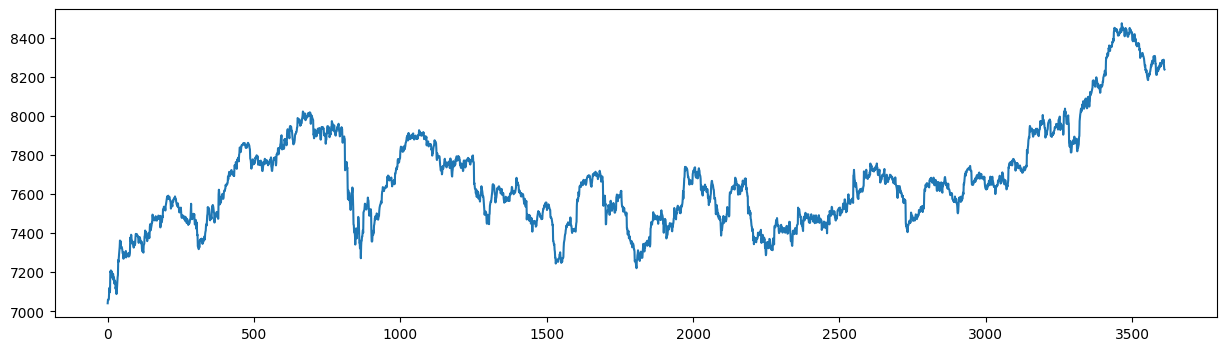

In [84]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(range(len(train)), train["Close"])
plt.show()

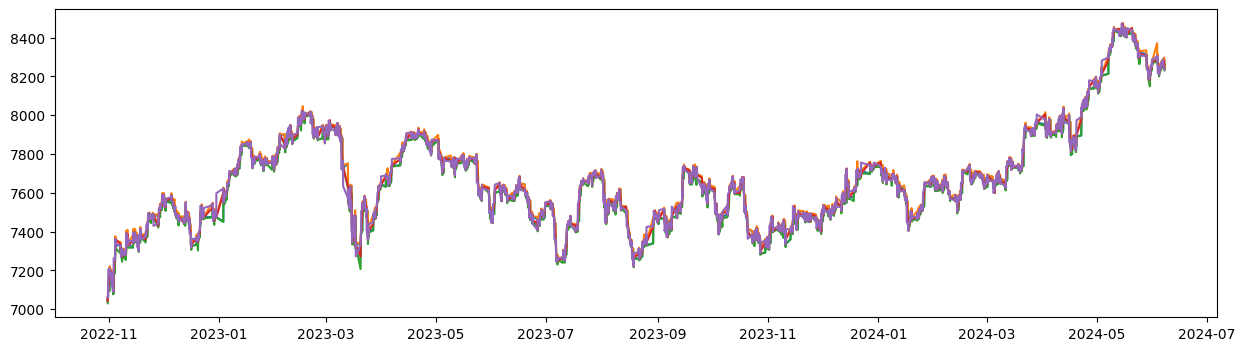

In [85]:
plt.figure(figsize=(15, 4))
plt.plot(train)
plt.show()

In [86]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,-1:])
    data = scaler2.fit_transform(data.iloc[:,:4])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [87]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 4
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 4
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [88]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [89]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [90]:
print(X_train.shape)
X_train[0][0]

torch.Size([3602, 10, 4])


tensor([-2.4197, -2.4377, -2.4382, -2.4465])

In [91]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [92]:
batch_size = 5
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = ShallowRegressionLSTM(num_sensors=4, hidden_units= 6)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

In [93]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)

count = 0
for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = modelQ(x)

        label = y.squeeze(1)
        #print(output)
        #print(label)
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)} ')

[1/5]  LossQ:87.0471174553386 
[2/5]  LossQ:17.260649792224285 
[3/5]  LossQ:13.015721004994703 
[4/5]  LossQ:11.760135896922293 
[5/5]  LossQ:10.964552553137764 


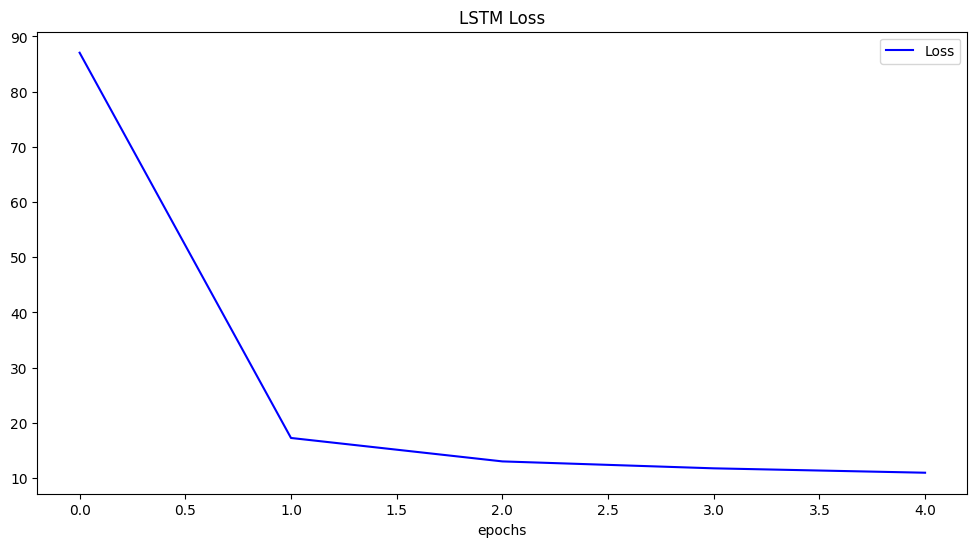

In [94]:
np.savetxt('./SavedModels/Stock/FTSE/loss/clstm.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('LSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [95]:
pred_y_train = modelQ(X_train)
pred_y_test = modelQ(X_test)

print(pred_y_train)

tensor([-1.0295, -1.0450, -1.0187,  ...,  2.2627,  2.2516,  2.2308],
       grad_fn=<ViewBackward0>)


In [96]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)


In [97]:
pred_y_train

tensor([[-1.0295],
        [-1.0450],
        [-1.0187],
        ...,
        [ 2.2627],
        [ 2.2516],
        [ 2.2308]], grad_fn=<ViewBackward0>)

In [98]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [99]:
np.savetxt('./SavedModels/Stock/FTSE/train/clstm.txt',y_train_pred)
np.savetxt('./SavedModels/Stock/FTSE/test/clstm.txt',y_test_pred)

Training dataset RMSE:112.58234571933684


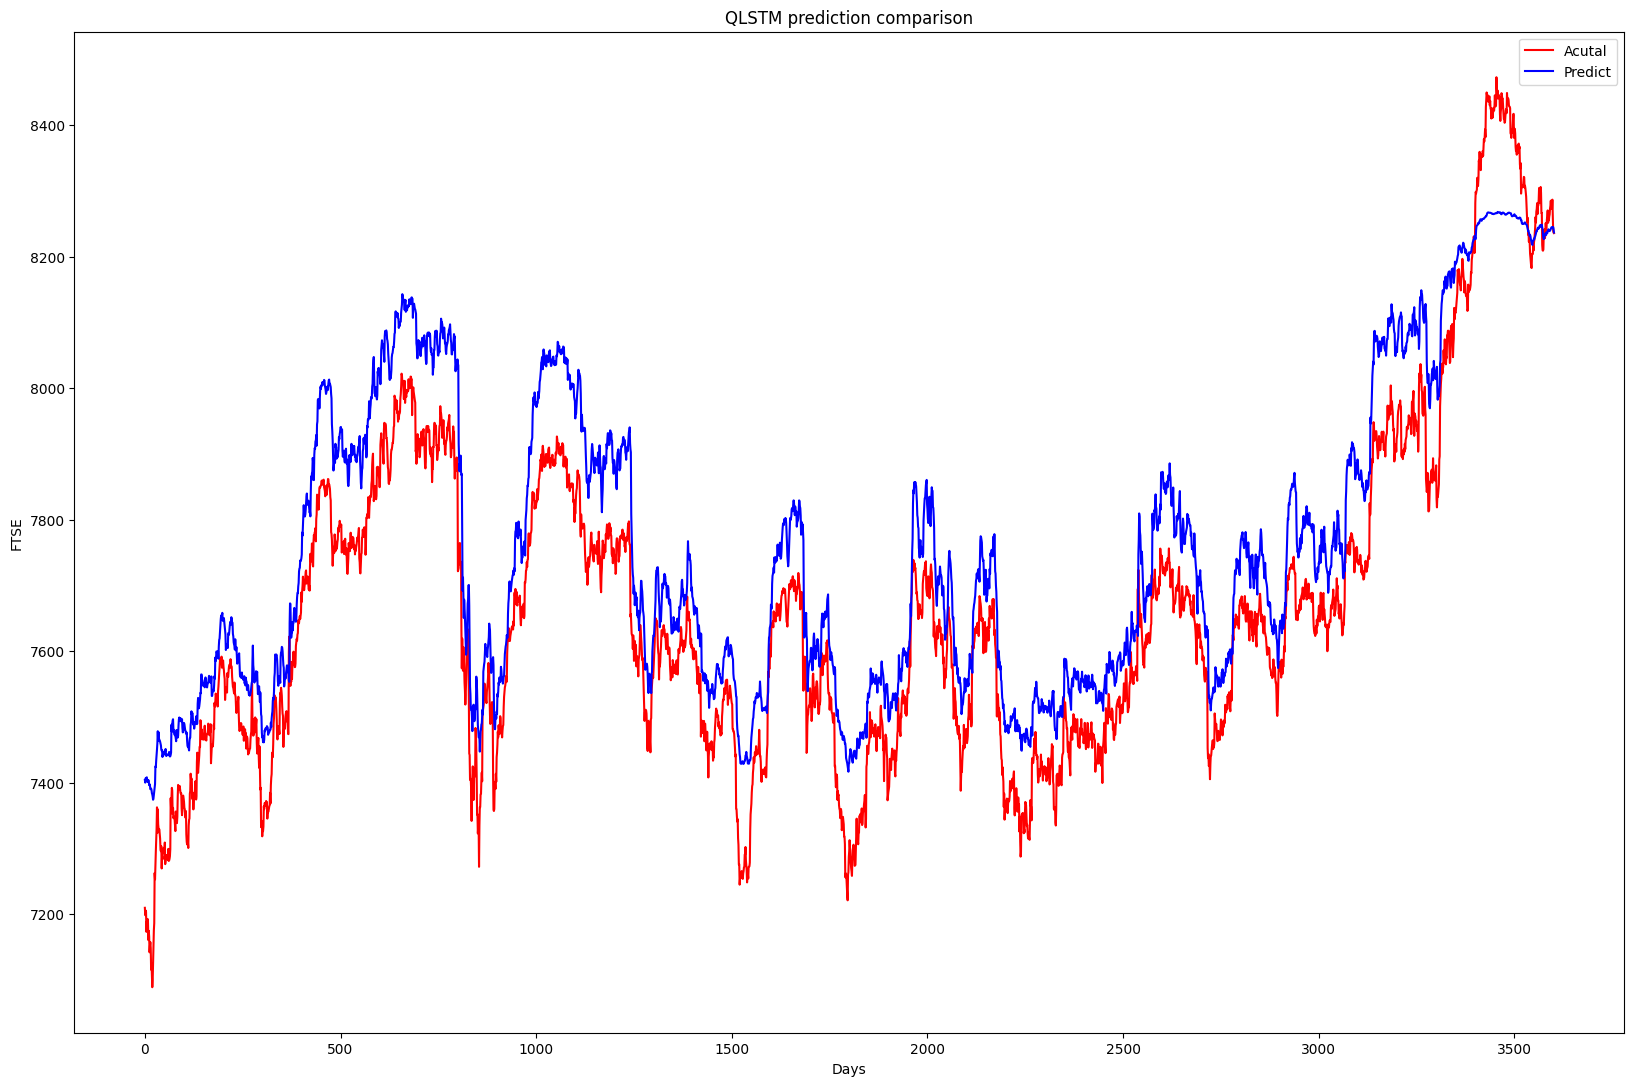

In [100]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('FTSE')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')
#50.548854456445106

Training dataset RMSE:47.50621283280725


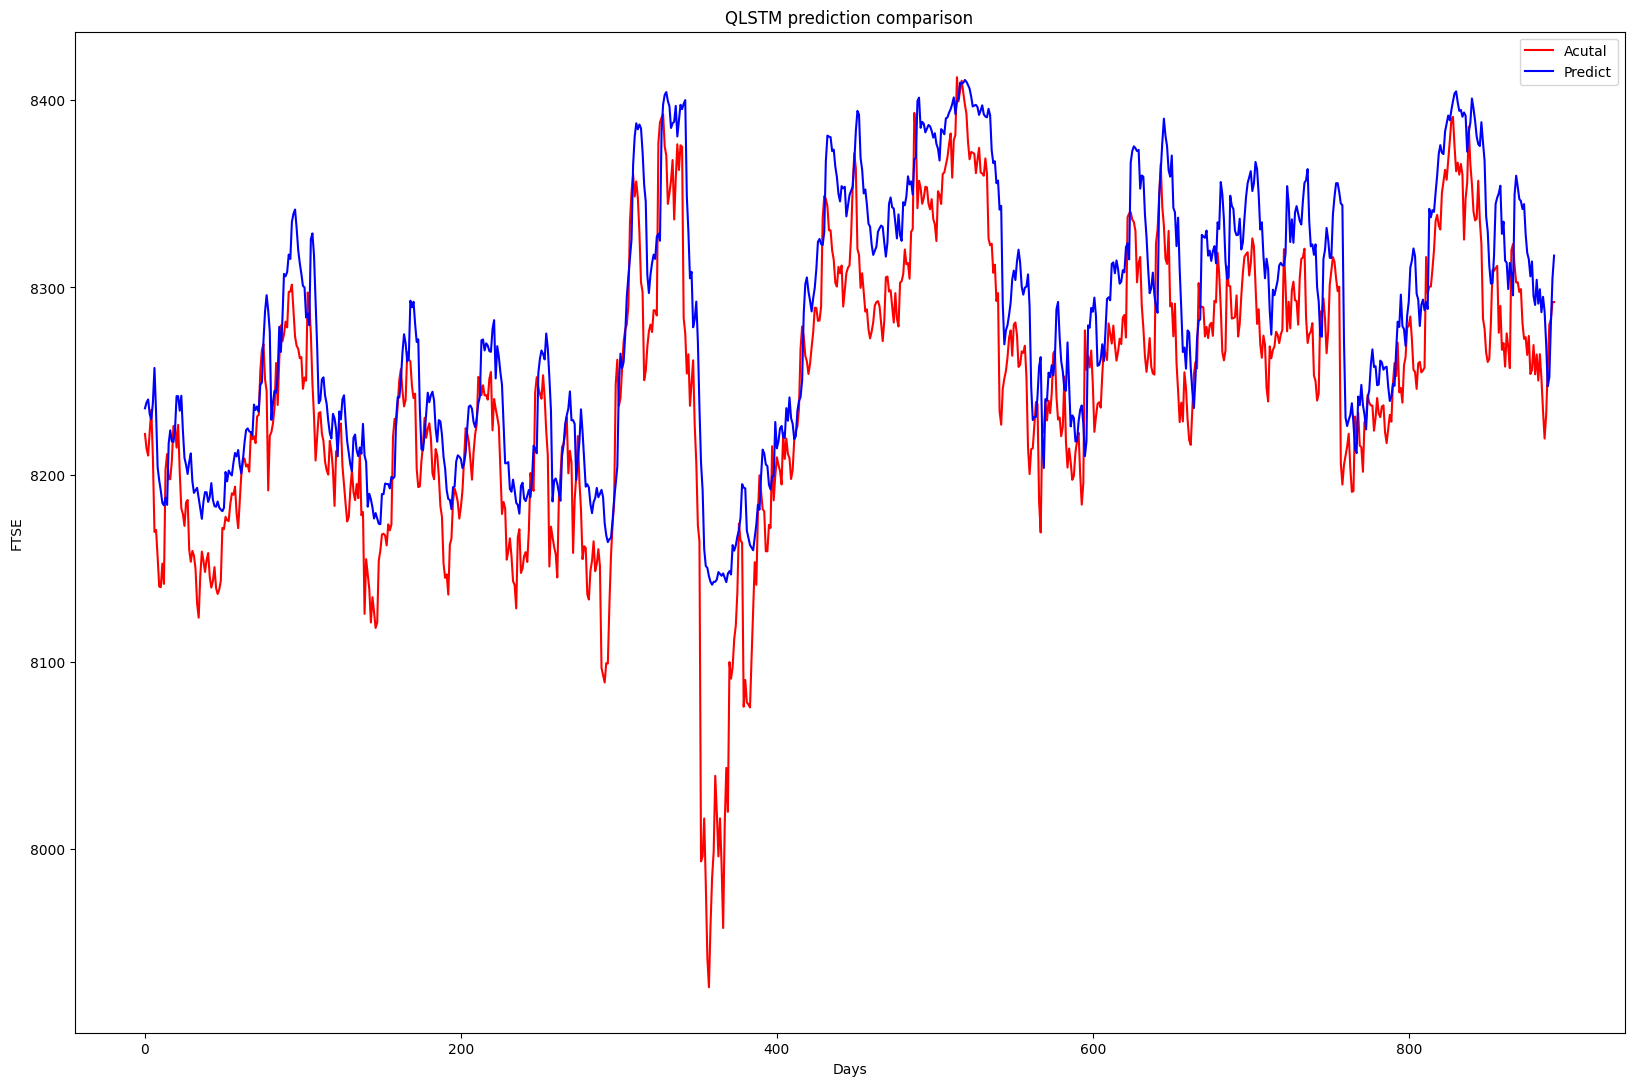

In [101]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('FTSE')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')
#47.50621283280725


In [102]:
torch.save(modelQ,'./SavedModels/Stock/FTSE/model/CLSTM_aqi')